<a href="https://colab.research.google.com/github/lucas-fpaiva/tcc_pes/blob/main/preprocessing/pre_processamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entendendo o problema de predição de saude da aeronave

Objetivos:

* Separar duas aeronaves para o teste final 
* Selecionar duas das séries para analisar dentro das aeronaves de treino
* Visualizar e realizar o preprocessamento dos dados
* Aplicar um modelo de predição usando uma para treinar e outra para testar

In [1]:
print("Estou rodando no Colab (S/N)?")
ambiente = input()
ambiente=ambiente.upper()

if ambiente == "S":
  from google.colab import drive
  import os

  drive.mount('/content/drive',force_remount=True)
  os.chdir('/content/drive/Shareddrives/TCC_PES/codigos/Piloto')

Estou rodando no Colab (S/N)?
s
Mounted at /content/drive


## Tratamento e organização inicial dos dados

In [2]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import plotly as py
import matplotlib.gridspec as gridspec

from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import SimpleRNN as RNN
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error

### Importação dos dados

In [3]:
#importando direto do github
data_feat = pd.read_csv('https://raw.githubusercontent.com/lucas-fpaiva/tcc_pes/main/data/caracteristica.csv')
data_health = pd.read_csv('https://raw.githubusercontent.com/lucas-fpaiva/tcc_pes/main/data/saude.csv')

### Separação de duas aeronaves para o teste final

In [4]:
np.random.seed(123)
np.random.randint(0,2,10)
teste = np.random.choice(np.unique(data_health.COD_AENV),2)
print("Aviões usados para teste: ", teste)

data_health  = data_health[data_health.COD_AENV != teste[0]][data_health.COD_AENV != teste[1]]

data_feat = data_feat[data_feat.COD_AENV != teste[0]][data_feat.COD_AENV != teste[1]]

print("Aviões usados para teste: ", np.unique(data_health.COD_AENV))


Aviões usados para teste:  [9834 9747]
Aviões usados para teste:  [1011 9486 9526 9636 9664 9678 9770 9793]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


### Calculo da mediana do desgaste e do valor da caracteristica por dia

União dos dois datasets

In [5]:
data_health = data_health.groupby(by=['COD_FALH','COD_AENV','DT_PROC']).median().reset_index()
data_feat = data_feat.groupby(by=['COD_FALH','COD_AENV','COD_EVNT']).median().reset_index()


data_health['id']=data_health.index
data_health.head()
data = pd.merge(data_feat, data_health, on=['COD_EVNT','COD_FALH','COD_AENV']).sort_values('DT_PROC')
data.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:1218: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


,COD_FALH,COD_AENV,COD_EVNT,COD_CARAC_NOM,VLR_CARAC,DT_PROC,VLR_DESG,id
3471,23,1011,116846,72.0,0.809445,2010-01-11,56.136860,6702
10389,35,1011,116846,63.0,0.000000,2010-01-11,4.396998,20114
6929,24,1011,116846,72.0,0.418330,2010-01-11,56.621538,13408
9906,24,9793,116311,72.0,0.000000,2010-01-11,60.415650,19291
6447,23,9793,116311,72.0,0.539028,2010-01-11,66.982252,12585


### Vizualização das séries

In [6]:
# Visualizando a Falha 23
px.line(data[data.COD_FALH==23], x='DT_PROC', y='VLR_DESG', color='COD_AENV')

In [7]:
# Visualizando a Falha 35
px.line(data[data.COD_FALH==35], x='DT_PROC', y='VLR_DESG', color='COD_AENV')

In [8]:
px.line(data[data.COD_FALH==35], x='DT_PROC', y='VLR_CARAC', color='COD_AENV')

##Testando filtros

In [9]:
def filtro(desgaste,tipo):
  if tipo == 'media_movel':
    w = 2
    desgaste_filt = np.convolve(desgaste, np.ones(w), 'valid') / w
  
  return desgaste_filt

In [81]:
def quebra_filt(desgaste,dist):
  quebras = []
  desgaste_filt = filtro(desgaste,'media_movel')
  a=0
  for i in range(0,len(desgaste_filt)-1):
    if abs(desgaste_filt[i]-desgaste_filt[i+1])>dist:
      if (a == 0):
        a = 1
      else:
        quebras.append(i)   
        a = 0      

  quebras = np.array(quebras)

  return quebras

In [11]:
def desg_uti(desgaste,quebras,look_back):

  des_uti = []
  n_pontos = look_back+10
  a=0
  for i in range(0,len(desgaste)-1):
    if i in quebras:
      if len(desgaste[a:i])>=n_pontos:
        des_uti = des_uti + desgaste[a:i+1].tolist()
      else:
        des_uti = des_uti + len(desgaste[a:i+1])*[-2]
        #print(a)
      a = i+1
  if len(desgaste[a:])>=n_pontos:
    des_uti = des_uti + desgaste[a:].tolist()
  else:
    des_uti = des_uti + len(desgaste[a:])*[-2]

  return des_uti

In [12]:
def descont(data,cod_falha,look_back,dist,lim):

  for aeronave in np.unique(data.COD_AENV):
    aero_data = data[(data.COD_AENV==aeronave)  & (data.COD_FALH==cod_falha)]
    desgaste = aero_data.VLR_DESG.values
    quebra = quebra_filt(desgaste,dist)
    des_uti = desg_uti(desgaste,quebra,look_back)
    func_plot(desgaste,quebra,aeronave,des_uti,lim)

In [13]:
def func_plot (desgaste,quebras,aeronave,des_uti,lim):
  plt.figure(figsize=(15, 2),dpi=300)
  #plt.plot(carac,'xr',label='Carac')
  plt.plot(desgaste,'ok',label='Desgaste real', markersize=2)
  plt.plot(des_uti, 'or',label='Desgaste utilizado', markersize=2)
  plt.legend()
  plt.title(aeronave)
  plt.grid()
  plt.ylim([lim[0],lim[1]])
  plt.vlines(quebras, 0, 100)
  

### Falha 35

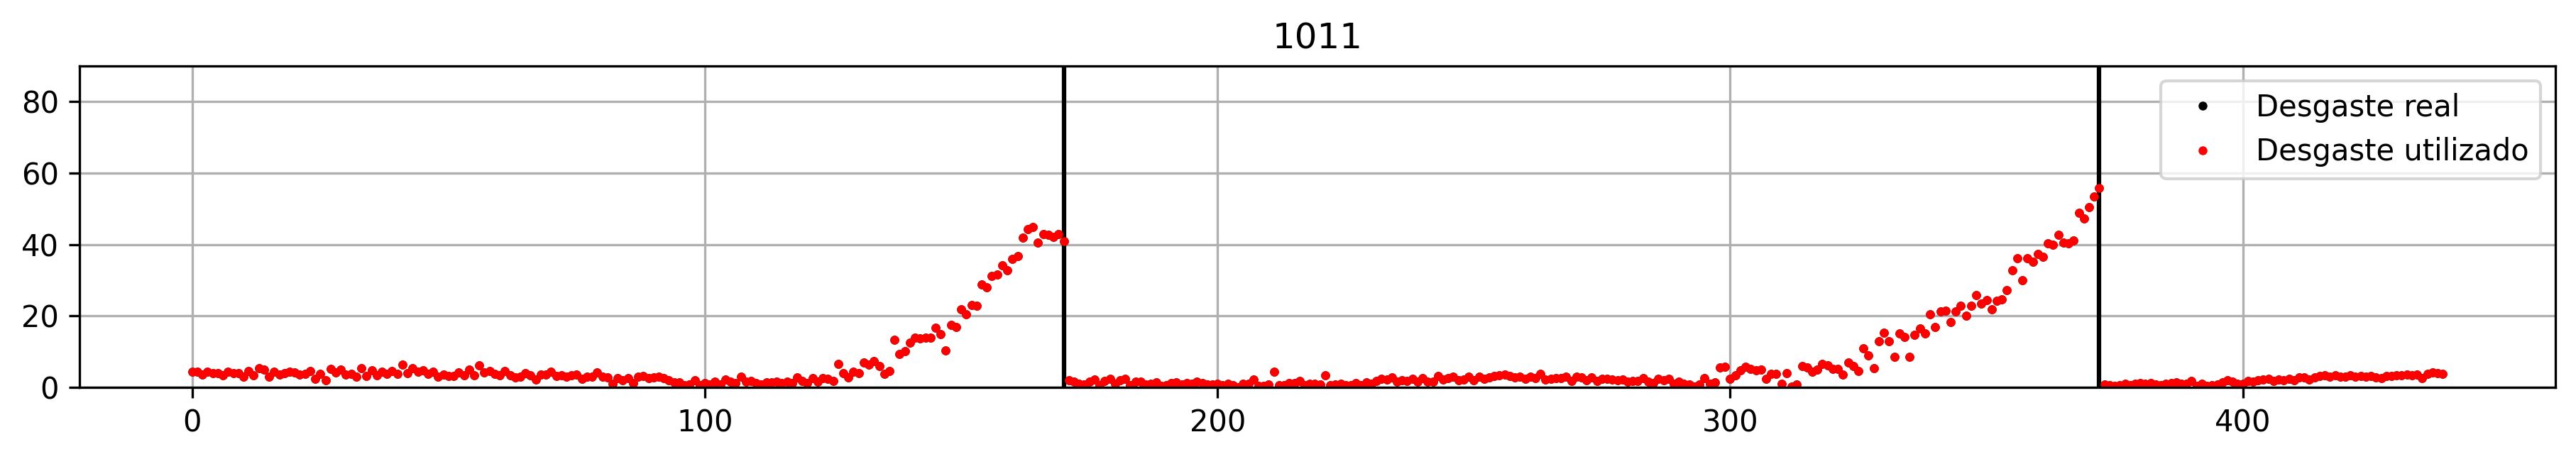

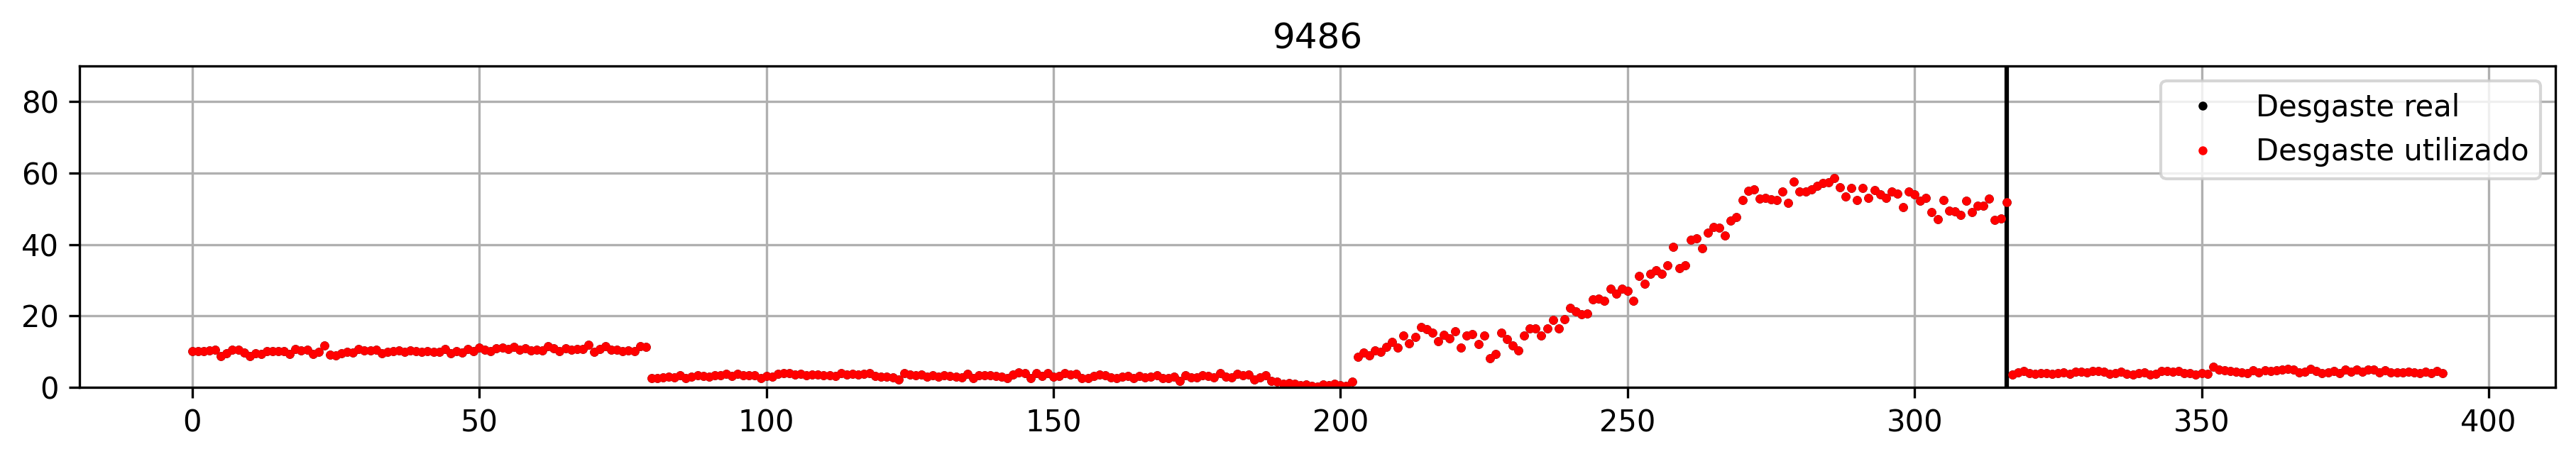

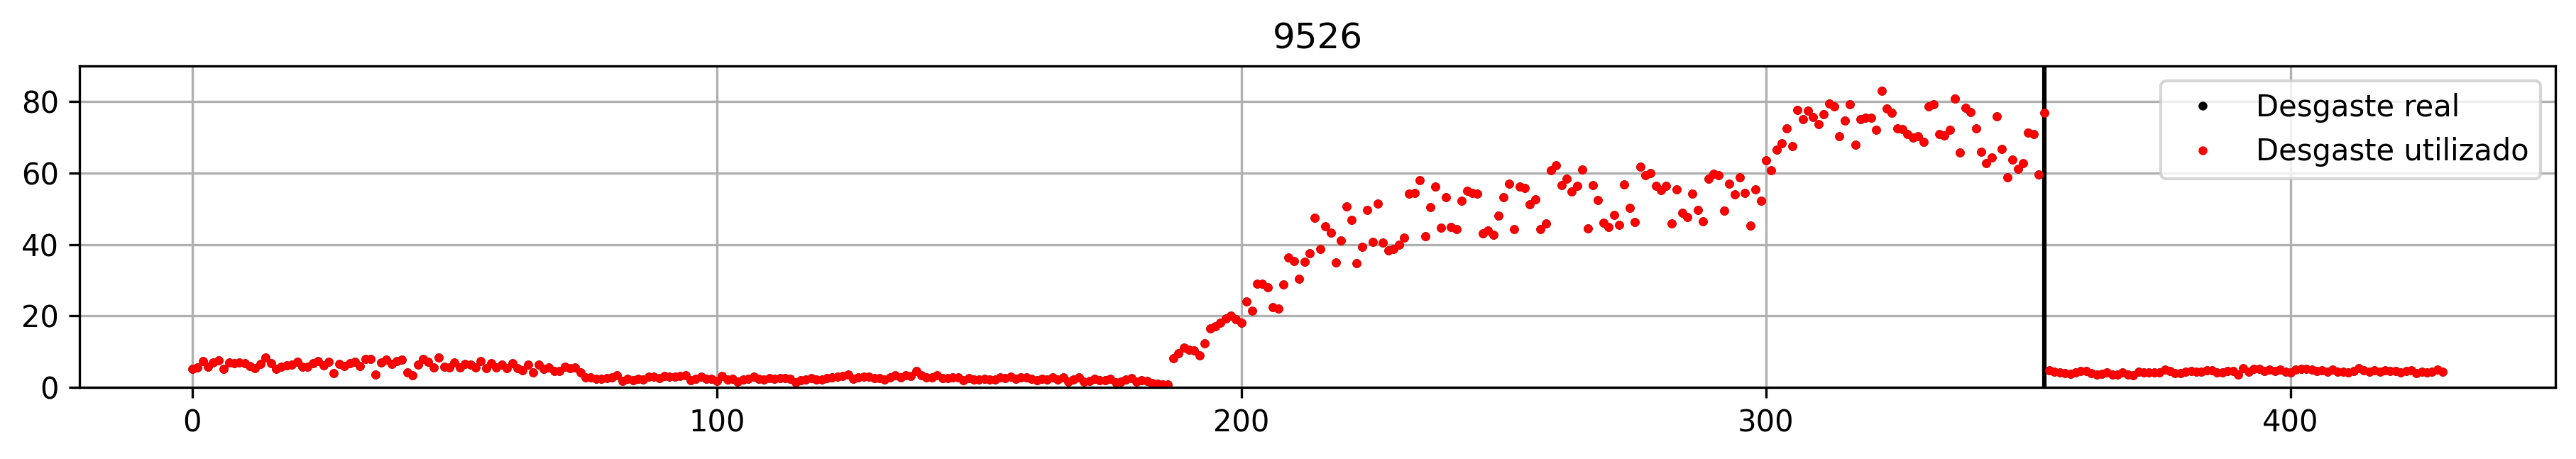

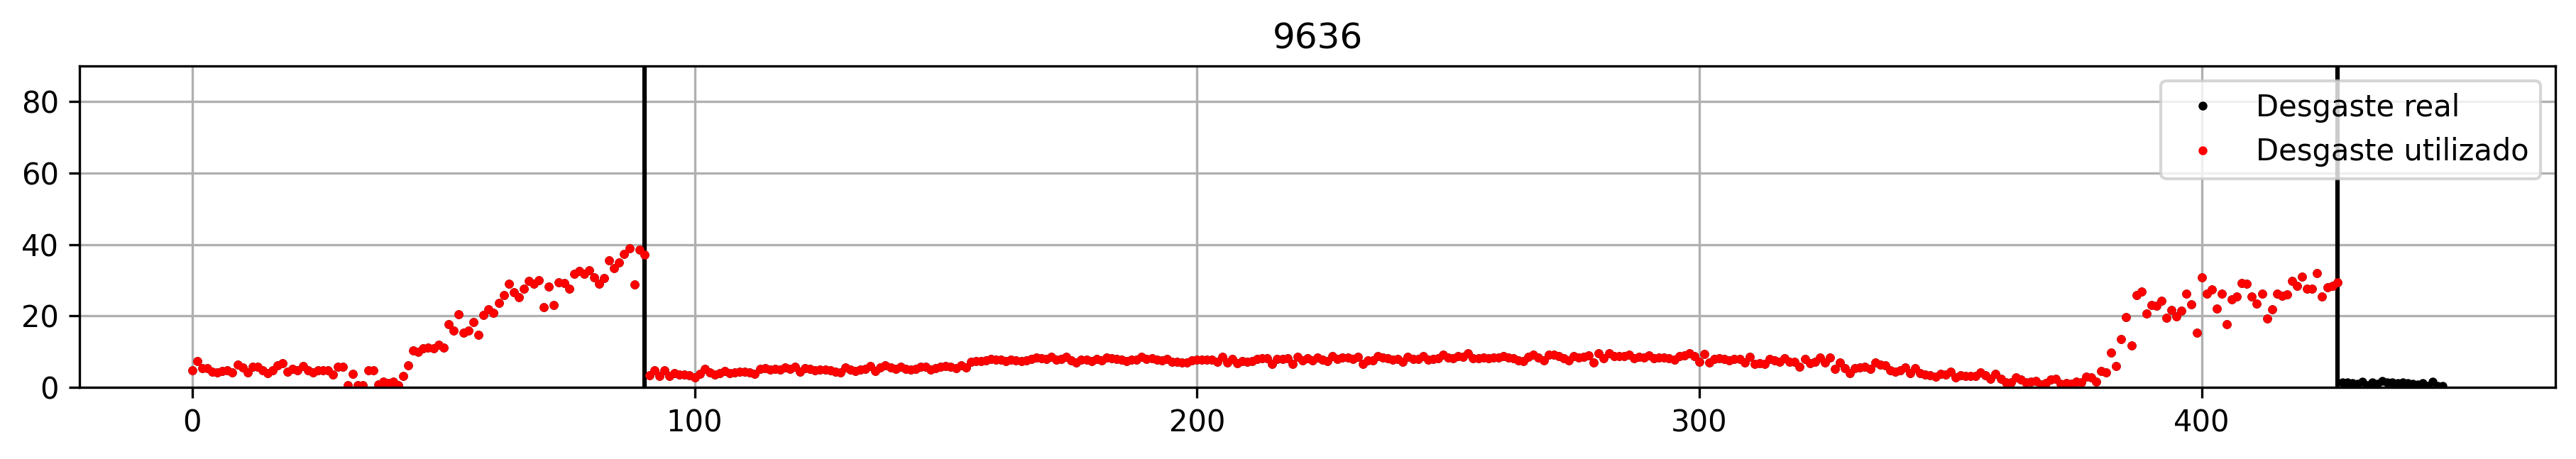

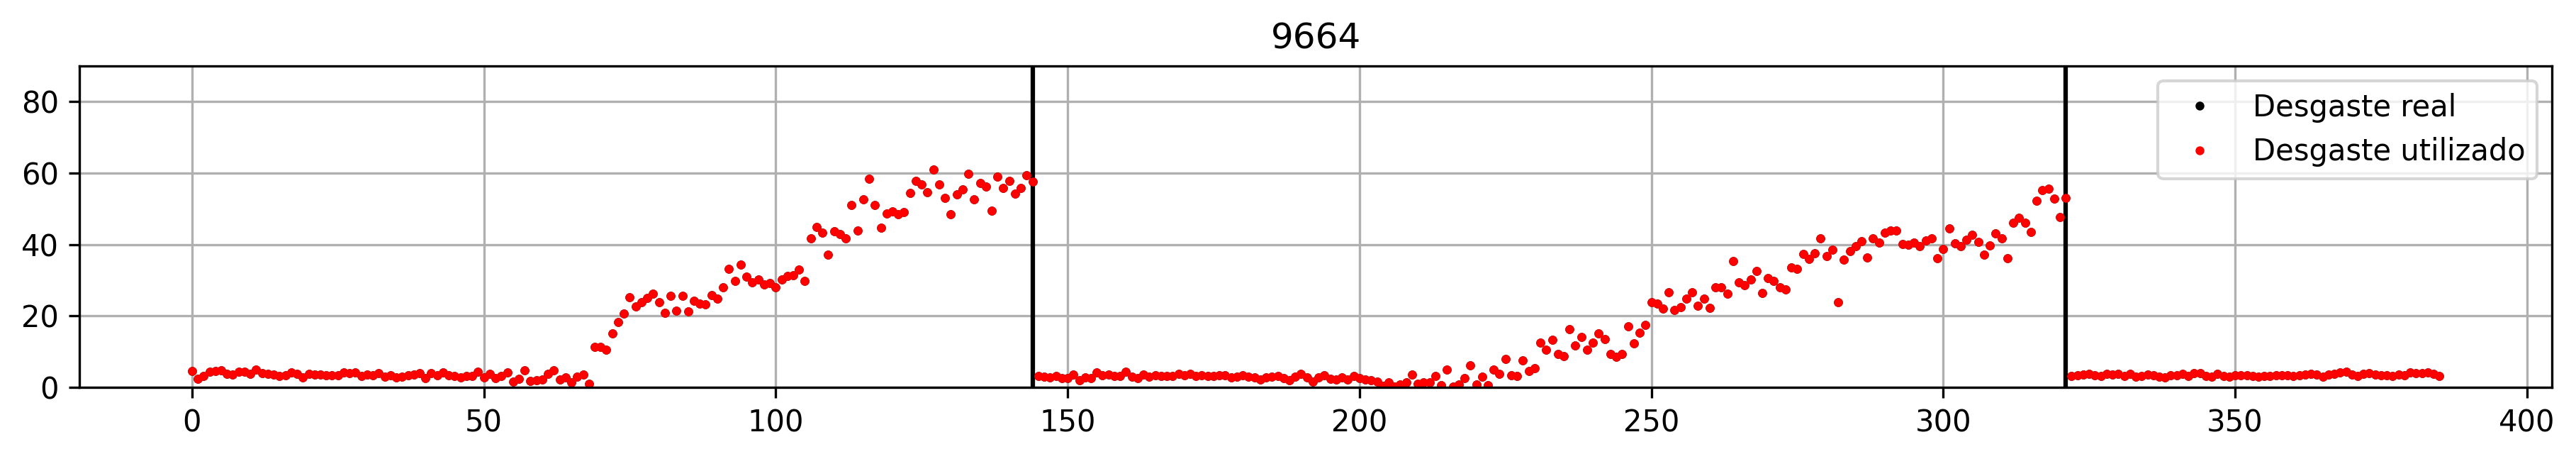

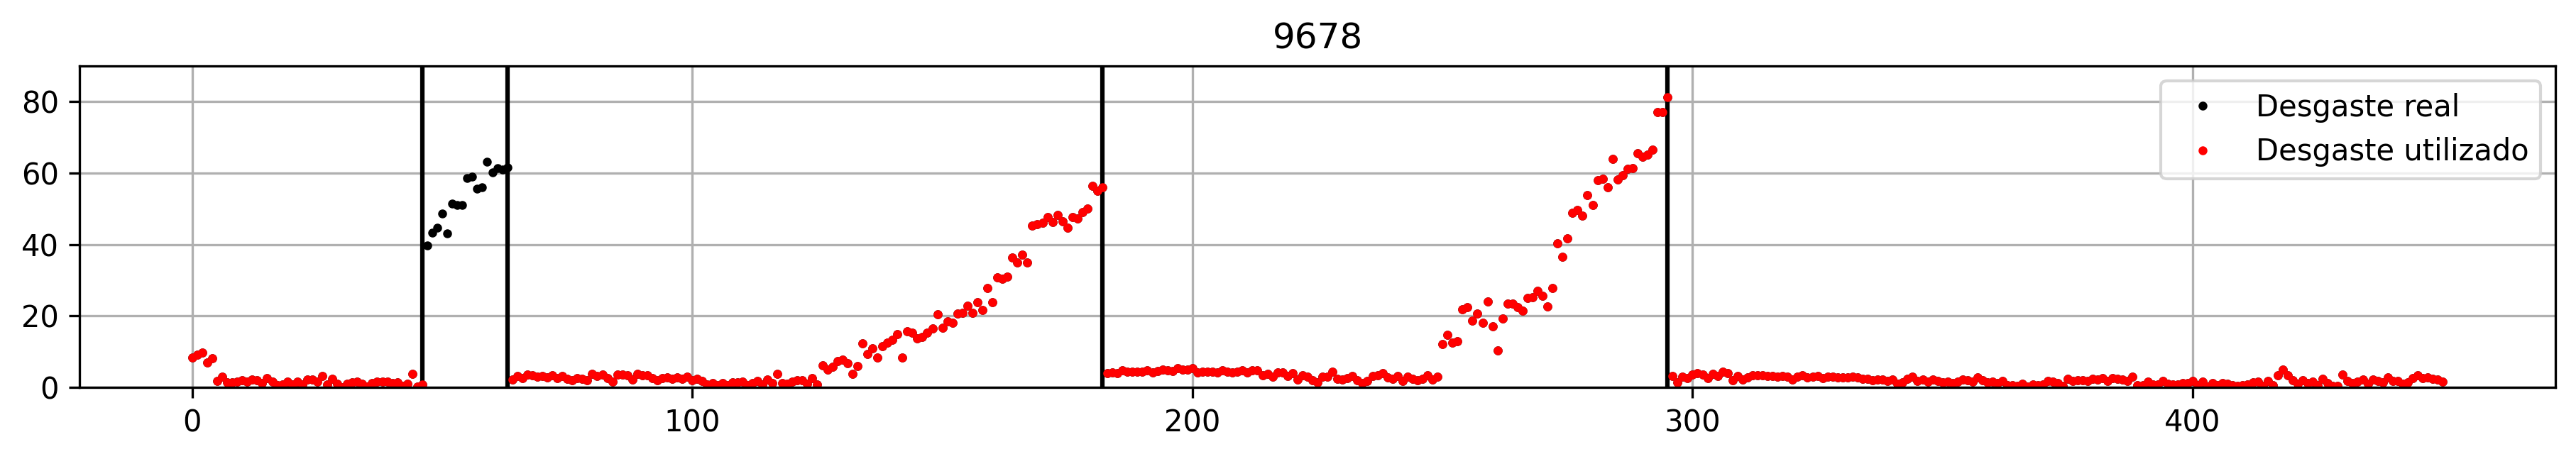

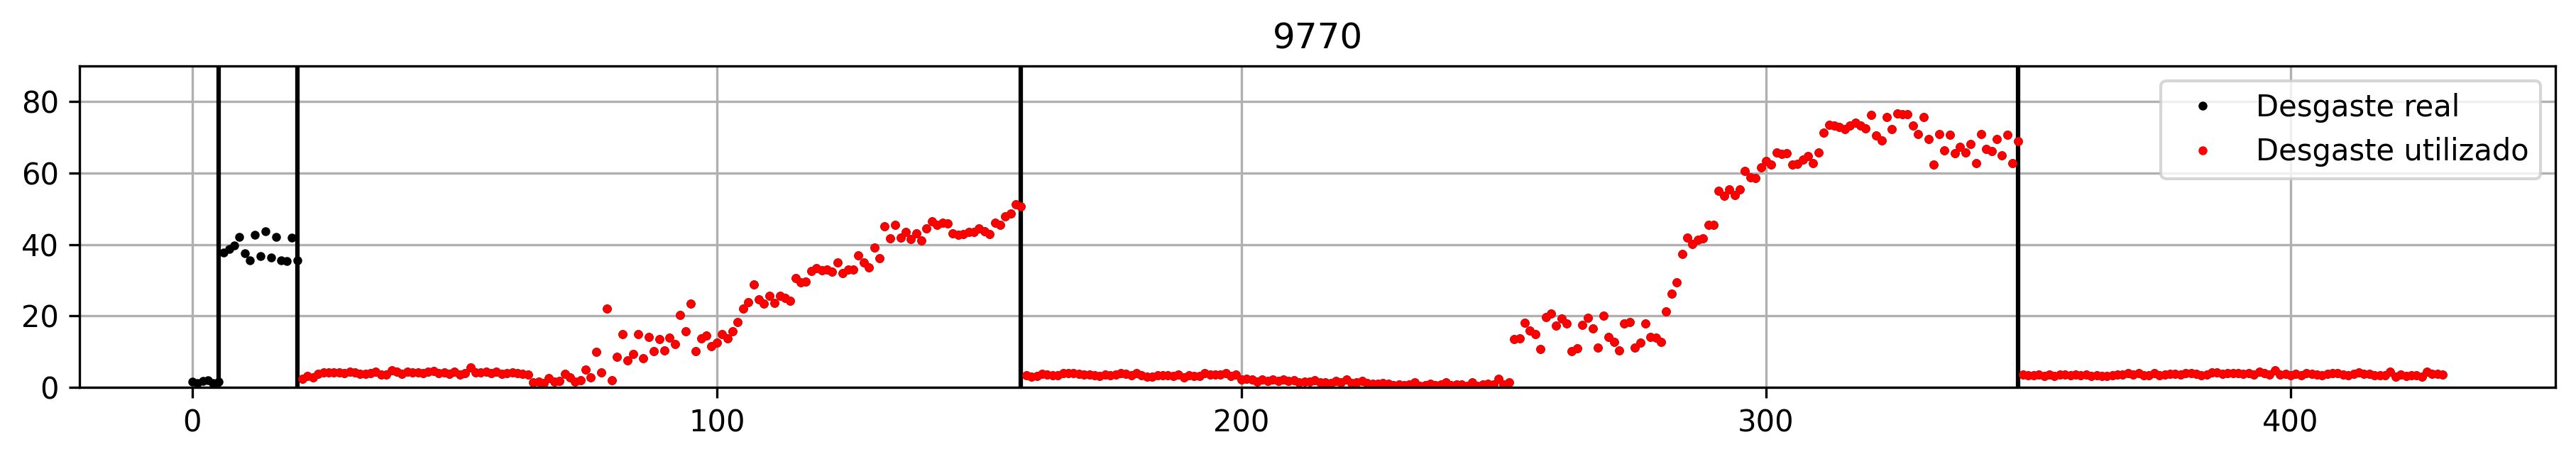

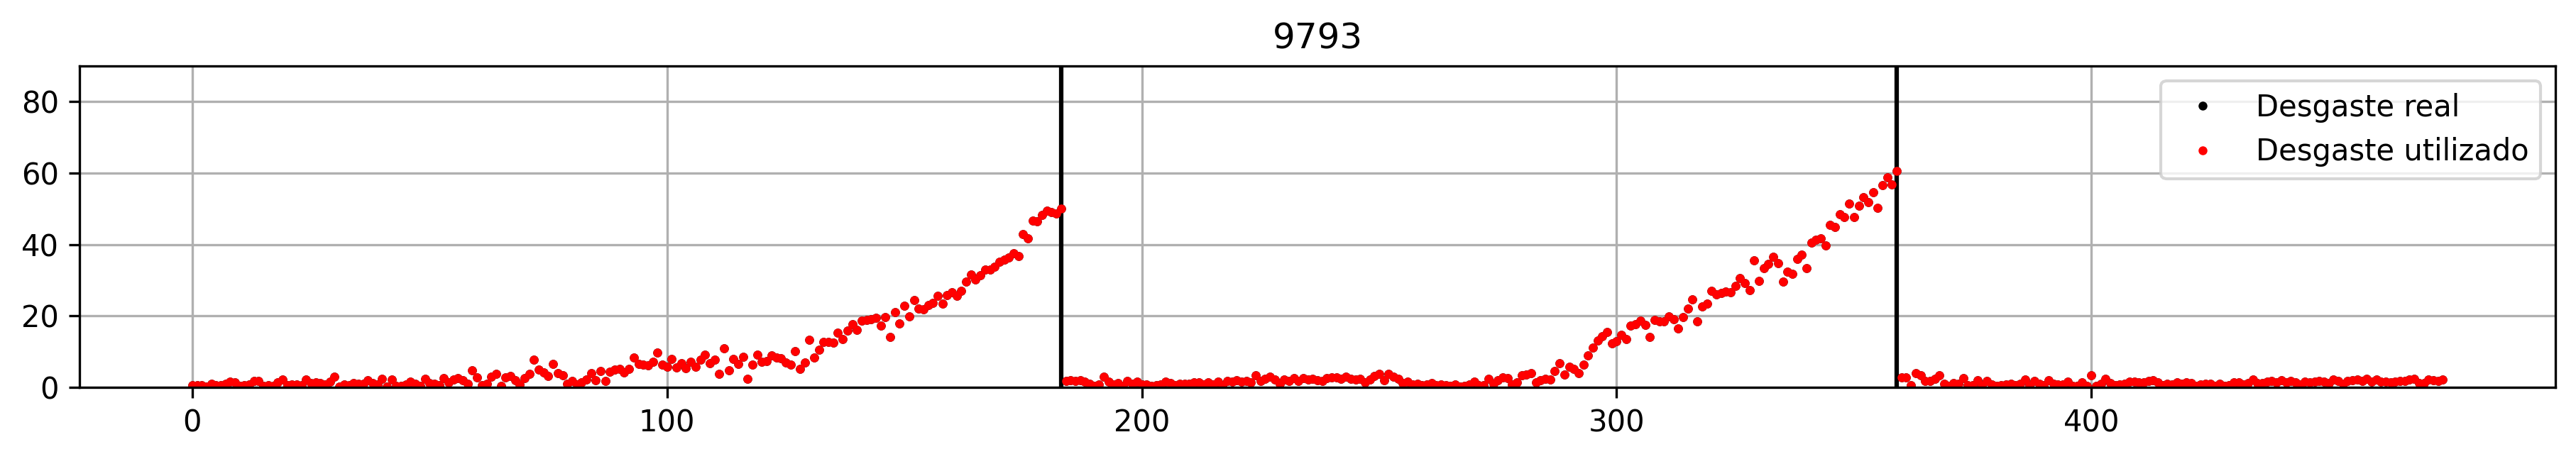

In [96]:
dist = 10 #distancia de pontos para considerar um quebra
cod_falha = 35 #1, 23, 24 e 35
look_back=20 #dias usados para predição
lim = [0,90] #Limites do eixo y
aeronaves = np.unique(data.COD_AENV)
descont(data,cod_falha,look_back,dist,lim)

## Separação das amostras

In [92]:
def quebra_filt(desgaste,dist = 10):
  quebras = []
  desgaste_filt = filtro(desgaste,'media_movel')
  a=0
  for i in range(0,len(desgaste_filt)-1):
    if abs(desgaste_filt[i]-desgaste_filt[i+1])>dist:
      if (a == 0):
        a = 1
      else:
        quebras.append(i)   
        a = 0      

  quebras = np.array(quebras)

  return quebras

def separa_amostras (data, cod_falha, look_back):
  subtrecho=[]
  subtrecho_dia=[]
  n = look_back+10

  for aeronave in np.unique(data.COD_AENV):
      aero_data = data[(data.COD_AENV==aeronave)  & (data.COD_FALH==cod_falha)]
      desgaste = aero_data.VLR_DESG.values
      dia = aero_data.DT_PROC.values
      quebra = quebra_filt(desgaste)
      quebra=np.append(quebra, len(desgaste)-1) #insere o fim do trecho
      init=0
      for i in range(0,len(quebra)):
        trecho=desgaste[init:quebra[i]+1]
        trecho_dia = dia[init:quebra[i]+1]
        init=quebra[i]+1
        if len(trecho)>=look_back+10:
            for i in range(0,len(trecho)-n+1):
              trecho_m = trecho[i:i+n].tolist()
              trechodia_m = trecho_dia[i:i+n].tolist()
              trechodia_m.append(aeronave)
              trecho_m.append(aeronave)
              subtrecho.append(trecho_m)
              subtrecho_dia.append(trechodia_m)
      
  subtrecho = np.array(subtrecho)
  subtrecho_dia = np.array(subtrecho_dia)
  return  subtrecho, subtrecho_dia 

def separa_treino_teste (amostras, aero_test, look_back, reshape,tipo): 
  data_train = amostras[amostras[:, look_back+10] != aero_test][:, 0:look_back+10]
  data_test = amostras[amostras[:, look_back+10] == aero_test][:, 0:look_back+10]

  x_train = data_train[:,0:look_back]
  y_train = data_train[:,look_back+9]
  x_test = data_test[:,0:look_back]
  y_test = data_test[:,look_back+9]

  x_train, scaler = normaliza_amostras(x_train, tipo="MinMax")
  x_test = scaler.transform(x_test)
  y_train, scaler = normaliza_amostras(y_train.reshape(-1, 1), tipo="MinMax")
  y_test = scaler.transform(y_test.reshape(-1, 1))

  if reshape==True:
      x_train = np.reshape(x_train, (x_train.shape[0],1, x_train[0].shape[0])) #reshape para treinar os modelos recorrentes
      y_train = np.reshape(y_train, (y_train.shape[0],1, 1))
      x_test  = np.reshape(x_test , (x_test.shape[0], 1, x_test[0].shape[0])) #reshape para testar os modelos recorrentes
      y_test = np.reshape(y_test, (y_test.shape[0], 1,1))

  return x_train, y_train, x_test, y_test, scaler

def plot_results(testPredict):
  rmse = mean_squared_error(y_test, testPredict, squared = False)
  plt.figure(dpi=100,figsize=(20,5))
  plt.plot(y_test,':ok')
  plt.plot(testPredict,'-xm')
  plt.title("Aeronave: "+ str(int(aero_test))+' | RMSE='+str(round(rmse,3)))
  plt.xlabel("Dias")
  plt.ylabel("Desgaste")
  plt.legend(["Esperado",'Predito'])
  # plt.ylim([0,80])

### Normalização das amostras

In [93]:
from sklearn.preprocessing import MinMaxScaler

def normaliza_amostras(amostras, tipo):
  if tipo=="MinMax":
    scaler = MinMaxScaler(feature_range=(-1, 1))
    amostras_scaler = scaler.fit_transform(amostras)
    return amostras_scaler, scaler
  else:
    return amostras

### Visualização das amostras


Text(0, 0.5, 'Desgaste (%)')

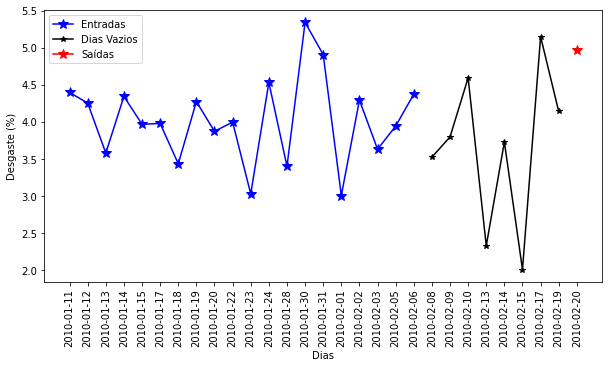

In [94]:
cod_falha = 35
look_back = 20

amostras, amostras_dia = separa_amostras (data, cod_falha, look_back)
amostras.shape

x=amostras[:,0:look_back]
y=amostras[:,look_back+9]

x_dia=amostras_dia[:,0:look_back]
y_dia=amostras_dia[:,look_back+9]

z=amostras[:,look_back+1:look_back+9]
z_dia=amostras_dia[:,look_back+1:look_back+9]

plt.figure(figsize=(10,5))
plt.plot(x_dia[0], x[0], "b-*", label="Entradas", markersize=10)
plt.xticks(rotation=90)
plt.plot(z_dia[0], z[0], "k-*", label="Dias Vazios")
plt.plot(y_dia[0], y[0], "r-*", label="Saídas", markersize=10)
plt.legend()
plt.xlabel("Dias")
plt.ylabel("Desgaste (%)")

13/13 [==============================] - 0s 2ms/step


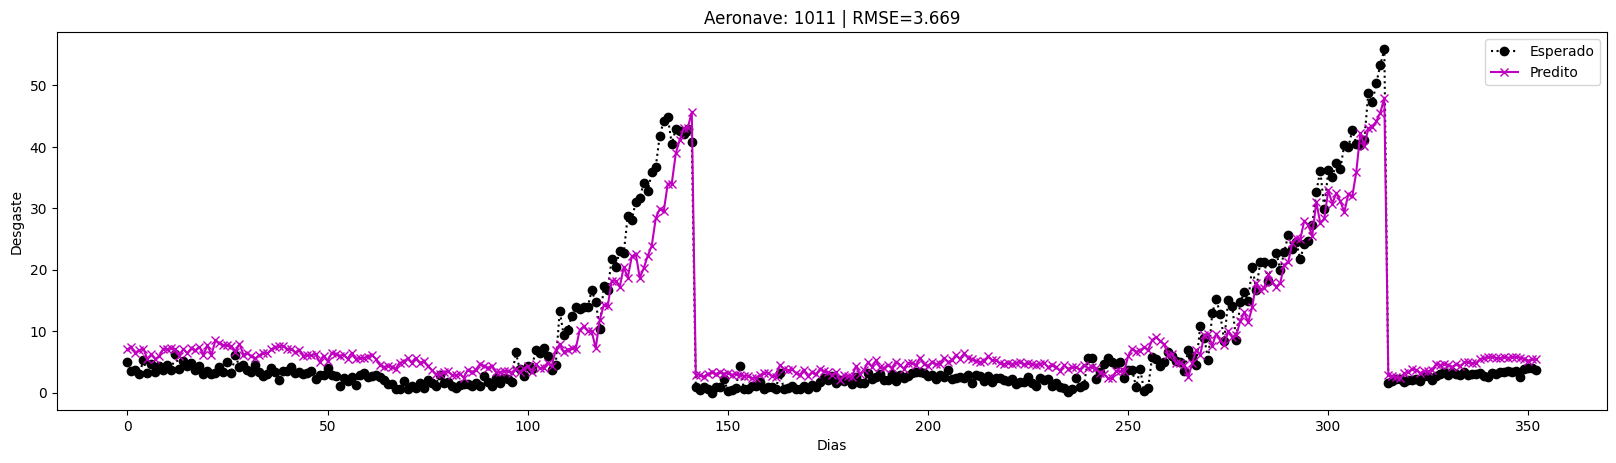

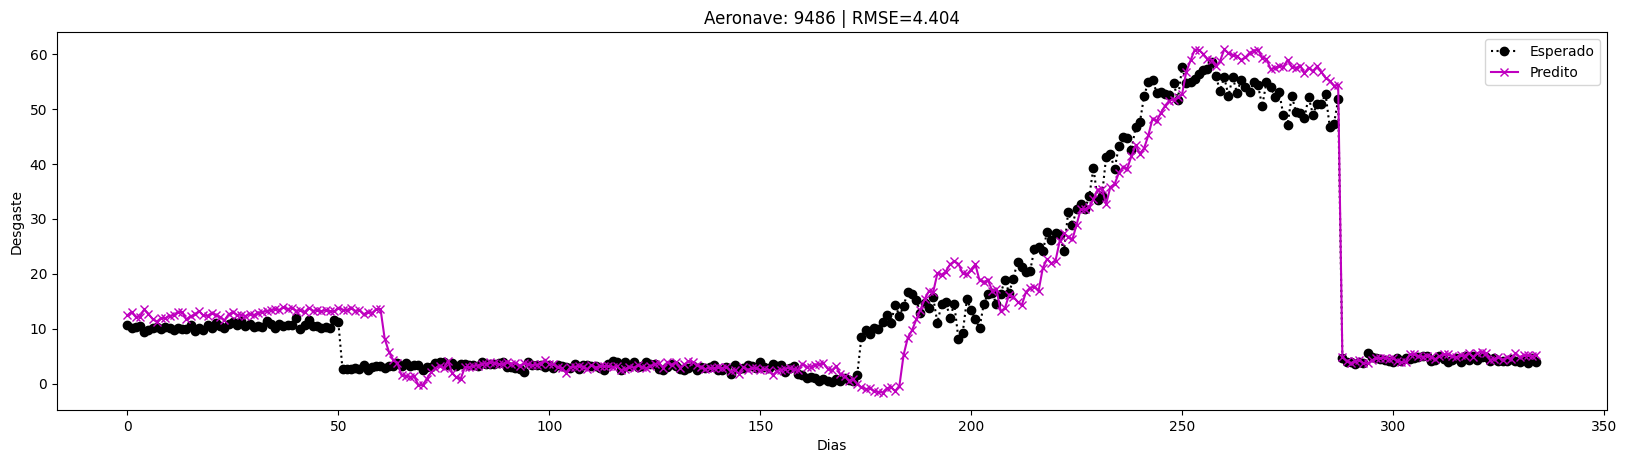

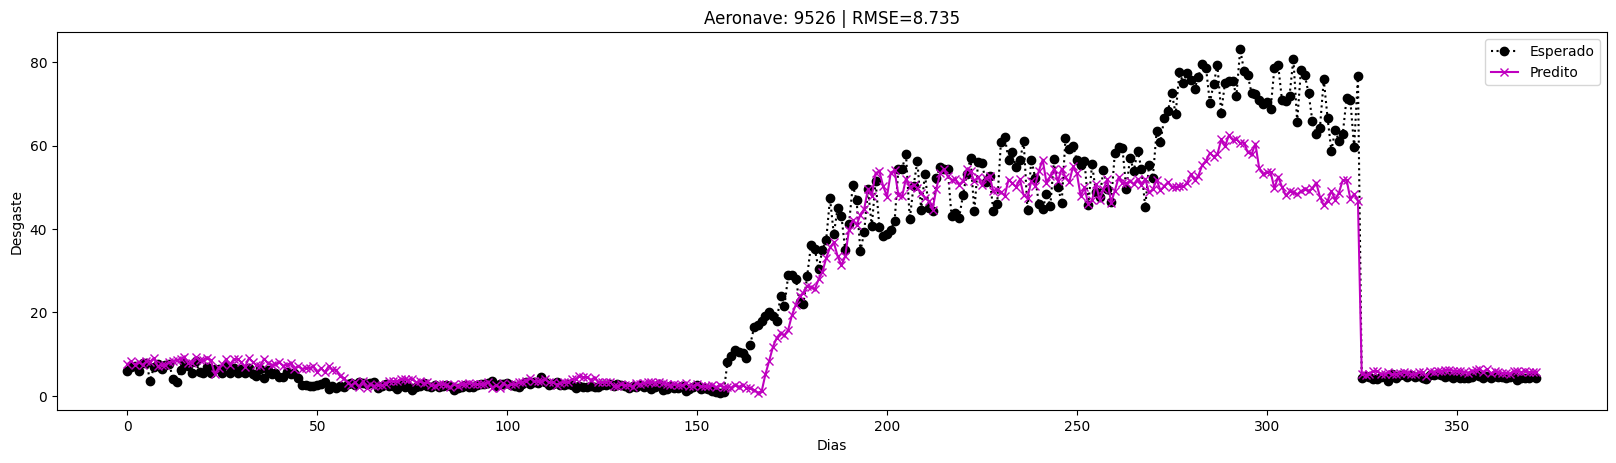

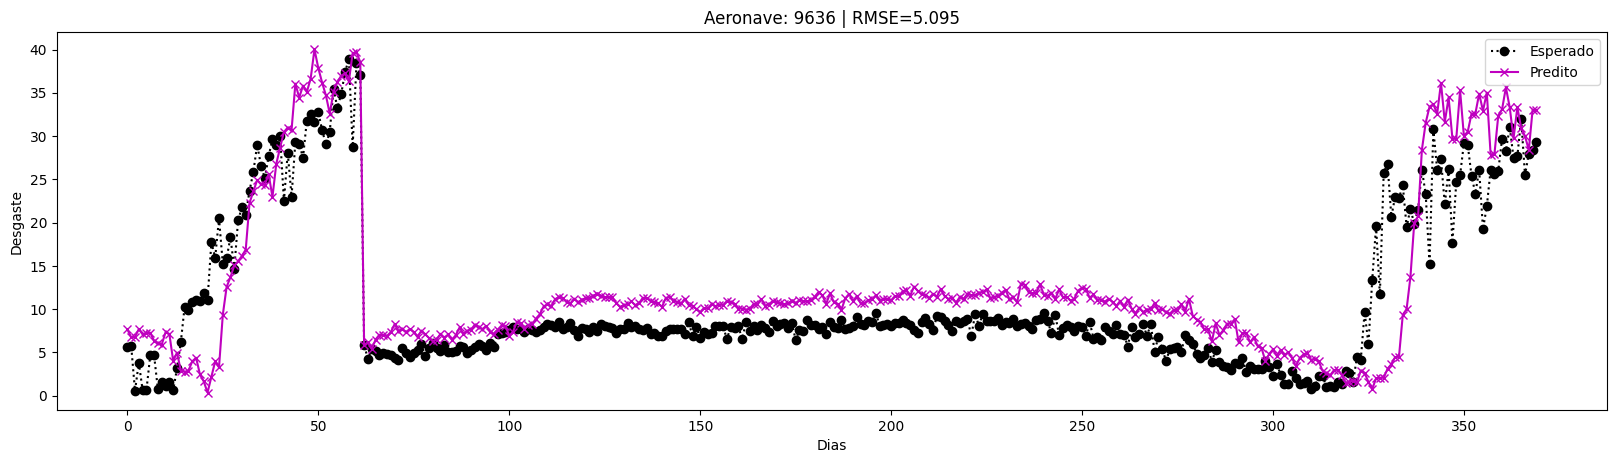

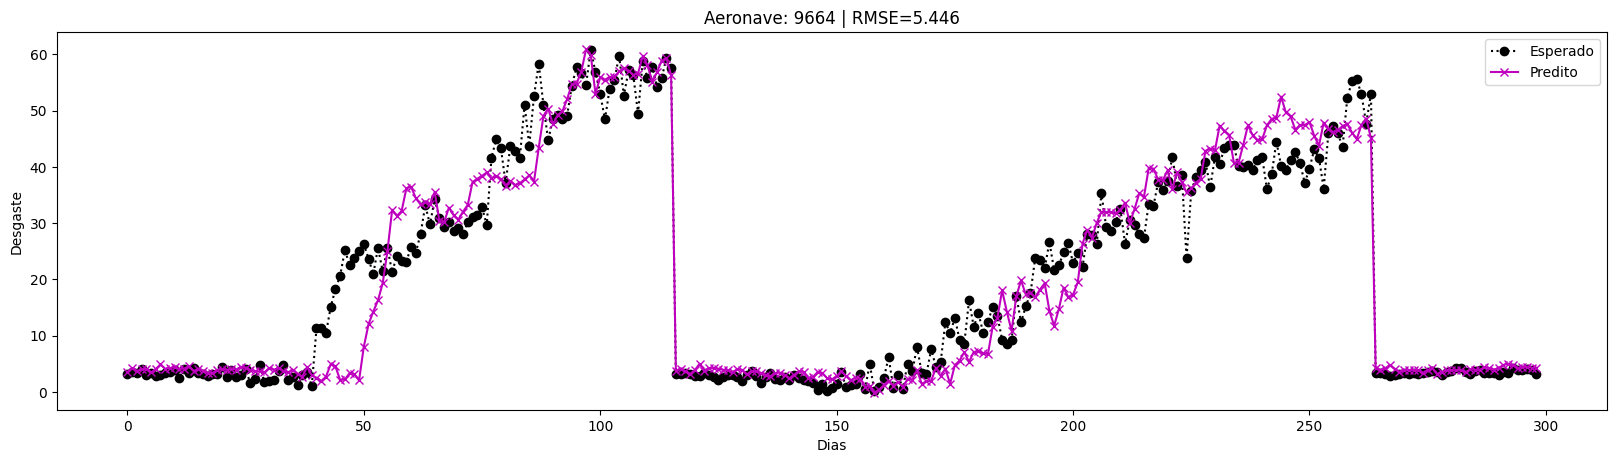

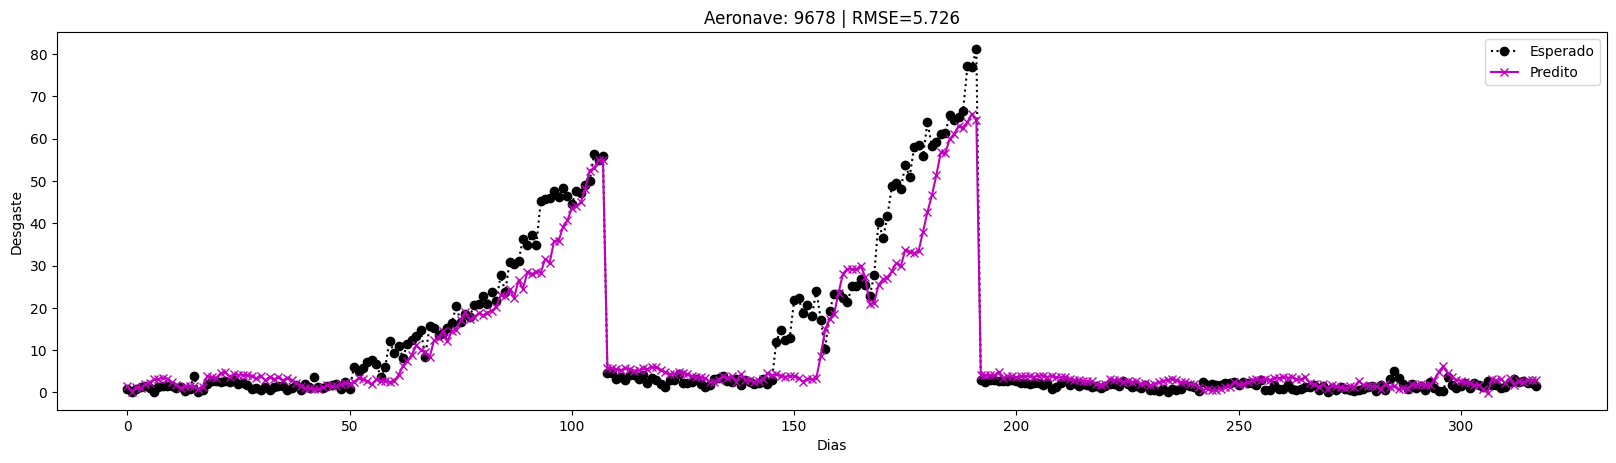

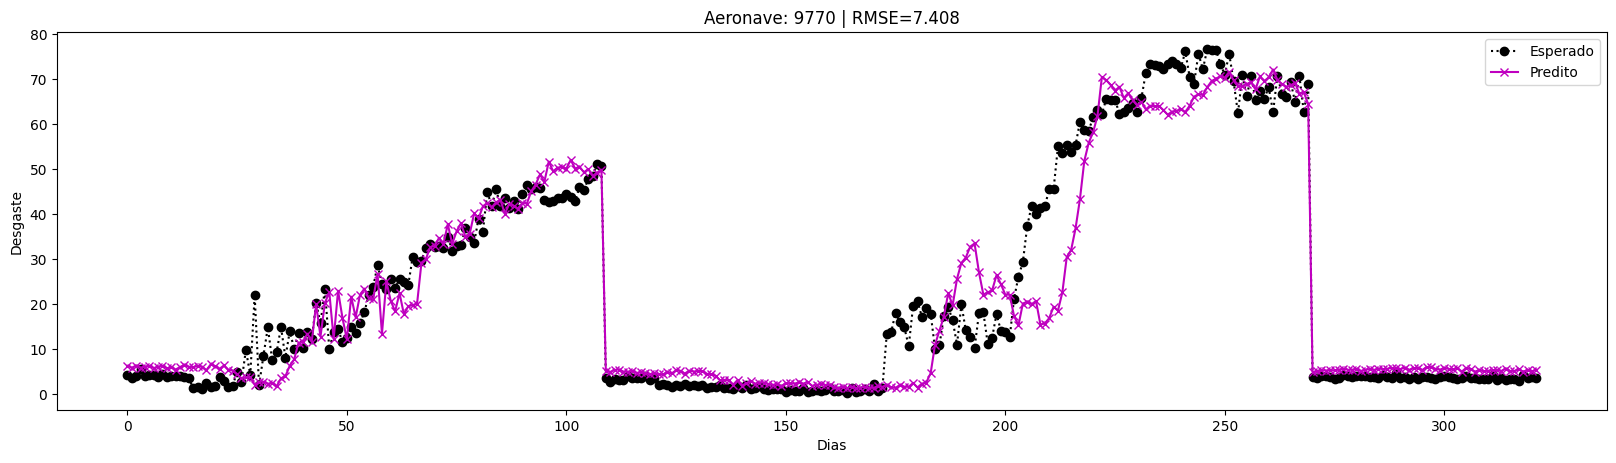

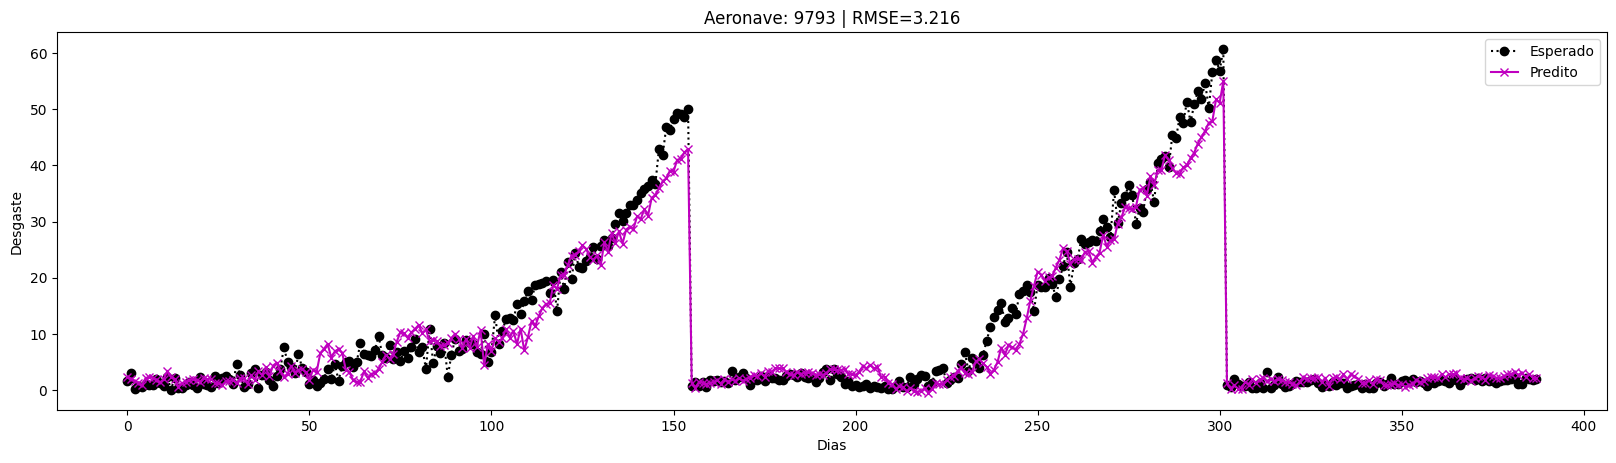

In [97]:
for aero_test in np.unique(data.COD_AENV):
      x_train, y_train, x_test, y_test, scaler = separa_treino_teste (amostras, aero_test, look_back, reshape = True, tipo="MinMax")

      model = Sequential()
      model.add(LSTM(5, activation=None,  input_shape=(1, look_back)))
      model.add(Dense(1))

      early_stopping = EarlyStopping(patience=5)
      model.compile(loss='mean_squared_error', optimizer='adam')
      model.fit(x_train, y_train, epochs=100, batch_size=10, validation_split=0.2, callbacks=[early_stopping], verbose=0)
      testPredict = model.predict(x_test)
      testPredict = scaler.inverse_transform(testPredict.reshape(-1,1))
      y_test = y_test[:,0]
      y_test = scaler.inverse_transform(y_test.reshape(-1,1))
      plot_results(testPredict)

In [17]:
#trainX, trainY, testX, testY = data_func(train_test, aero_test,look_back,deep=True)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)



(2561, 1, 10) (2561, 1, 1) (418, 1, 10) (418, 1)
